# EfficientNet
https://github.com/qubvel/efficientnet </br>

**모델의 크기를 키우는 3가지 방법** </br>
1) *width scaling*  : filter(channel)의 개수 늘리기 (mobileNet, shufflenet..)</br>
2) *depth scaling*  : layer의 갯수 늘리는 (Resnet...) </br>
3) *resolution scaling*: input image의 해상도를 높임 </br> 
=> 3가지 중 어느 기법을 쓸 것인가에 대해 가이드라인 존재 x, 일일히 실험해봐야하는 불편함 </br>
˙ 이에 EfficientNet 논문에서는 **Compound Scaling** 방법 제시 </br>
=> 모델(F)를 고정 후 3가지 scaling 방법을 모두 고려</br>



이미 구현되어있는 kears의 EfficientNet 활용


In [44]:
pip install keras-efficientnets

In [0]:
%tensorflow_version 1.x

In [0]:
# 1. 필요 모듈 import
import tensorflow as tf
import os, numpy as np
from keras_efficientnets import EfficientNetB0
from keras.layers import Dense, Input, Activation, Dropout
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import SGD
import matplotlib.pyplot as plt

In [47]:
# 2. npy 데이터를 불러와서 모델 학습
X_train, X_test, y_train, y_test = np.load("/content/drive/My Drive/last.npy", allow_pickle=True)
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')  
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}') 


X_train: (20802, 64, 64, 3), y_train: (20802, 5)
X_test: (5201, 64, 64, 3), y_test: (5201, 5)


In [48]:
import warnings
warnings.filterwarnings(action='ignore')

# 3. model 생성
inputs = (64, 64, 3)
model = EfficientNetB0(input_shape=inputs, include_top=False, weights='imagenet', pooling='max')
x = model.output
x = Dense(1024, name='fully', init='uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, init='uniform')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Activation('relu')(x)
x = Dense(5, activation='softmax')(x)
model = Model(model.input, x)

model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_544 (Conv2D)             (None, 32, 32, 32)   864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_417 (BatchN (None, 32, 32, 32)   128         conv2d_544[0][0]                 
__________________________________________________________________________________________________
swish_409 (Swish)               (None, 32, 32, 32)   0           batch_normalization_417[0][0]    
___________________________________________________________________________________________

In [0]:
# 4. 모델 컴파일
warnings.filterwarnings(action='ignore')
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.07, clipvalue=0.6), metrics=['accuracy'])  

In [50]:
# 5. 모델 학습
warnings.filterwarnings(action='ignore')
model_dir = "./model"
if not os.path.exists(model_dir):
  os.mkdir(model_dir)
model_path = model_dir + '/test.model'
checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
hist = model.fit(X_train, y_train, epochs=50, batch_size=200, callbacks=[checkpoint, early_stopping], validation_split=0.2)

Train on 16641 samples, validate on 4161 samples
Epoch 1/50
16641/16641 [==============================] - 29s 2ms/step - loss: 1.6234 - acc: 0.3681 - val_loss: 0.9449 - val_acc: 0.6667

Epoch 00001: val_loss improved from inf to 0.94493, saving model to ./model/test.model
Epoch 2/50
16641/16641 [==============================] - 11s 647us/step - loss: 0.9855 - acc: 0.6183 - val_loss: 0.6312 - val_acc: 0.7698

Epoch 00002: val_loss improved from 0.94493 to 0.63124, saving model to ./model/test.model
Epoch 3/50
16641/16641 [==============================] - 11s 647us/step - loss: 0.7054 - acc: 0.7319 - val_loss: 0.4954 - val_acc: 0.8169

Epoch 00003: val_loss improved from 0.63124 to 0.49542, saving model to ./model/test.model
Epoch 4/50
16641/16641 [==============================] - 11s 649us/step - loss: 0.5586 - acc: 0.7858 - val_loss: 0.4313 - val_acc: 0.8397

Epoch 00004: val_loss improved from 0.49542 to 0.43131, saving model to ./model/test.model
Epoch 5/50
16641/16641 [=========

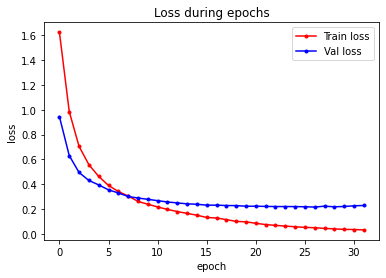

In [51]:
# loss 그래프
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

x = range(len(train_loss))
plt.plot(x, train_loss, marker='.', color='red', label='Train loss')
plt.plot(x, val_loss, marker='.', color='blue', label='Val loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss during epochs')
plt.show()

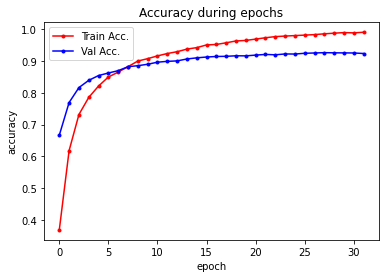

In [52]:
# acc 그래프
train_acc = hist.history['acc']
val_acc = hist.history['val_acc']

plt.plot(x, train_acc, marker='.', c='red', label='Train Acc.')
plt.plot(x, val_acc, marker='.', c='blue', label='Val Acc.')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy during epochs')
plt.show()

In [53]:
# Test set으로 모델 평가
score = model.evaluate(X_test, y_test, verbose=0)
print('Training loss:', score[0])
print('Training accuracy: ', score[1])

Training loss: 0.2157921550741358
Training accuracy:  0.9296289175273226


In [54]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix, classification_report
test_true = np.argmax(y_test, axis=1)
print(test_true)
test_pred = np.argmax(model.predict(X_test), axis=1)
print(test_pred)

cm = confusion_matrix(test_true, test_pred)
print(cm)

[0 3 3 ... 1 2 3]
[0 3 3 ... 1 2 3]
[[ 973    9   24    2    0]
 [   9  912  125    7    2]
 [  22  134  872    2    4]
 [   1    5    1 1138    6]
 [   4    0    3    6  940]]


In [55]:
# Classification Report
from sklearn.metrics import classification_report
report = classification_report(test_true, test_pred, target_names=os.listdir('/content/drive/My Drive/data_label'))
print(report)

              precision    recall  f1-score   support

       nevus       0.96      0.97      0.96      1008
          df       0.86      0.86      0.86      1055
      eschar       0.85      0.84      0.85      1034
          vl       0.99      0.99      0.99      1151
         mel       0.99      0.99      0.99       953

    accuracy                           0.93      5201
   macro avg       0.93      0.93      0.93      5201
weighted avg       0.93      0.93      0.93      5201



˙ EfficientNet의 원리 이해, 하지만 결과를 빨리 보고 싶어서 먼저 구현되어있는 keras 버전 EfficientNet를 활용해 테스트 </br>
˙ resnet50과 비교했을 때 한 epoch 당 학습 시간 약 6초 감소 </br>
˙ acc 2% 상승, classification report에서 eschar, vl, mel 세 부문 다 전반적인 정확도 상승 </br>
˙ 다음에는 torchver에 텐서보드 기능을 추가해서 밑바닥부터 만들어보자 

